In [1]:
import os 
import sys
import random 
import numpy as np 
import torch 
from torch.utils.data import DataLoader
import random
from tqdm import tqdm 
current_dir = '/share/projects/TaskTracker/'
sys.path.append(current_dir)

from training.dataset import ActivationsDatasetDynamicPrimaryText
from training.utils.constants import TEST_ACTIVATIONS_DIR_PER_MODEL, TEST_CLEAN_FILES_PER_MODEL, TEST_POISONED_FILES_PER_MODEL


MODEL = 'mistral'
BATCH_SIZE = 256
TEST_ACTIVATIONS_DIR = TEST_ACTIVATIONS_DIR_PER_MODEL[MODEL]
FILES_CHUNCK = 10 
LAYERS = 80 if MODEL == 'llama3_70b' else 32 

In [2]:
clean_files = TEST_CLEAN_FILES_PER_MODEL[MODEL]
print(f'{len(clean_files)} clean files')
poisoned_files = TEST_POISONED_FILES_PER_MODEL[MODEL]
print(f'{len(poisoned_files)} poisoned files')

32 clean files
32 poisoned files


In [3]:
def compute_distances(tensor1, tensor2):
    distances = torch.norm(tensor1 - tensor2, p=2, dim=-1)
    return distances

def compute_activations_residuals(evaluate_files):
    emb_diffs =  [[] for i in range(0,LAYERS)] 

    for i in range(0,len(evaluate_files),FILES_CHUNCK):
        files = evaluate_files[i:i+FILES_CHUNCK]
        dataset = ActivationsDatasetDynamicPrimaryText(files,LAYERS,TEST_ACTIVATIONS_DIR)
        data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
        for j, data in enumerate(data_loader):
            primary, primary_with_text = data 
            for layer in range(0,primary.size(1)):
                emb_diffs[layer].append(primary_with_text[:,layer,:] - primary[:,layer,:])
    emb_diffs_stacked = []
    for layer in range(0,LAYERS):
        emb_diffs_stacked.append(np.vstack(emb_diffs[layer]))
    return emb_diffs_stacked

In [4]:
diff_poisoned = compute_activations_residuals(poisoned_files)
diff_clean = compute_activations_residuals(clean_files)

In [5]:
from sklearn.manifold import TSNE
all_tsne_embs = []
for layer in range(0,len(diff_clean)):
    print(layer)
    combined_diffs = np.vstack((diff_clean[layer], diff_poisoned[layer]))
    labels = ['Clean' for _ in diff_clean[layer]] + ['Poisoned' for _ in diff_poisoned[layer]]
    tsne = TSNE(n_components=2, random_state=42)
    reduced_diff_embeddings = tsne.fit_transform(combined_diffs)
    all_tsne_embs.append(reduced_diff_embeddings)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


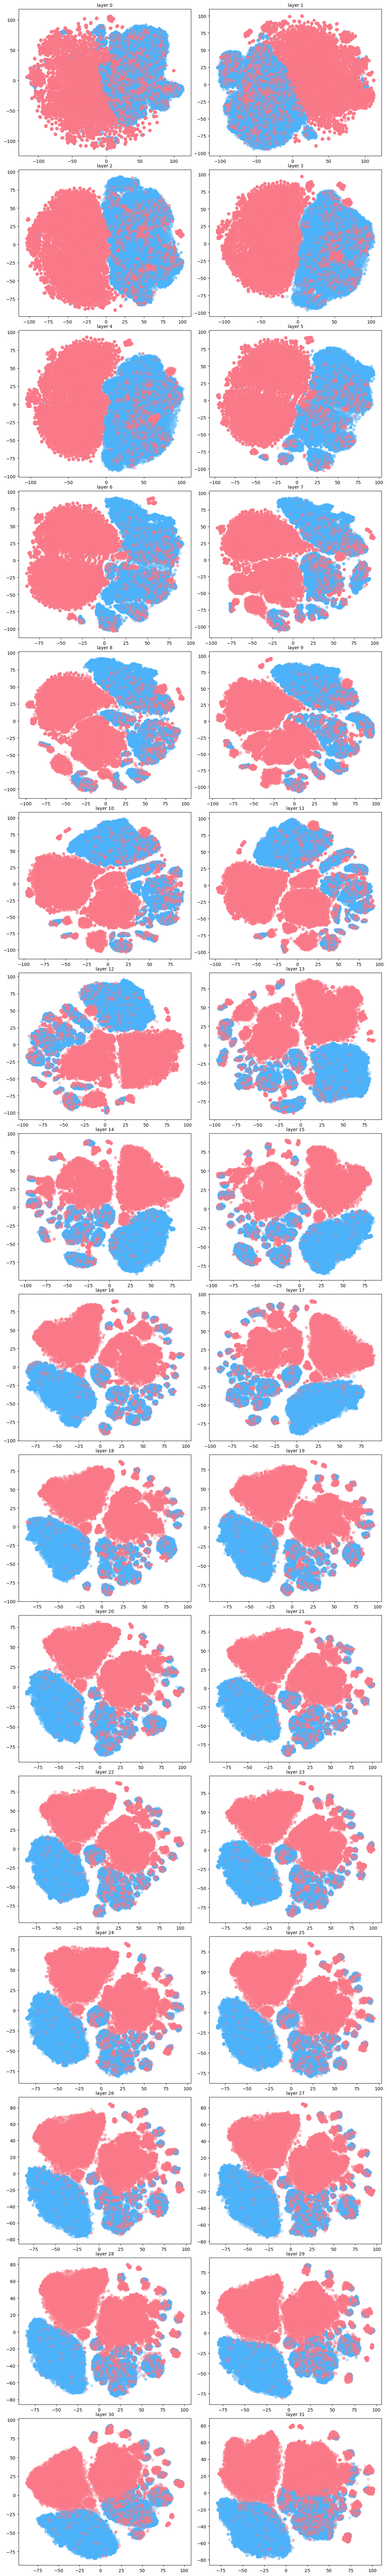

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(16, 2,  figsize=(12, 80))
fig.tight_layout(h_pad=1)

labels = ['Clean' for _ in diff_clean[0]] + ['Poisoned' for _ in diff_poisoned[0]]


layer_idx = 0
for i in range(0,len(axs)):
    if layer_idx == LAYERS: break 
    for j in range(0,len(axs[0])):
        if layer_idx == LAYERS: break 
        for label, color in zip(['Clean', 'Poisoned'], ['#4CB2F9', '#FA7988']):
            condition = np.array(labels) == label
            axs[i][j].scatter(all_tsne_embs[layer_idx][condition, 0], 
                all_tsne_embs[layer_idx][condition, 1], 
                c=color, 
                label=label, alpha=0.3)
            axs[i][j].set_title('layer ' + str(layer_idx), fontsize=10)
        layer_idx += 1